# Artificial Neural Network (ANN)

An artificial neural network (ANN) is a computational model inspired by the structure and functioning of the biological brain. It is a mathematical model composed of interconnected artificial neurons, also known as nodes or units. ANN is a fundamental concept in the field of machine learning and is used for various tasks such as pattern recognition, classification, regression, and optimization.

![image](https://assets-global.website-files.com/5fb24a974499e90dae242d98/620a60b07d89271b879c9e95_Illustrations%20for%20Blog%20Posts.png)

ANN is essentially a feed-forward network because of the way information travels through it — from one layer to another without touching a node twice. All layers are responsible for inputting, processing, and outputting data to the deeper layers. Such an interlayered system is what helps this Neural Network understand and learn complex things.


## Load Libraries and Dataset

In [1]:
# Import required libraries

import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import sqlite3
import pickle
import re

from collections import defaultdict
from sklearn.model_selection import train_test_split, KFold
from sklearn.metrics import classification_report, accuracy_score, confusion_matrix
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.models import Sequential, load_model
from tensorflow.keras.layers import Dense, Embedding, LSTM, SpatialDropout1D, SimpleRNN, Activation, Flatten
from tensorflow.keras import optimizers, callbacks
from tensorflow.keras import backend as K
from tensorflow.keras.callbacks import EarlyStopping


In [2]:
# Load dataset from database

db = sqlite3.connect('C:/Users/HP/BInar/WAN PLATINUM/database.db', check_same_thread = False)
q_data = 'SELECT * FROM data'
data = pd.read_sql_query(q_data, db)
data.head(10)

,Tweet,Label
0,warung ini dimiliki oleh pengusaha pabrik tahu...,positive
1,mohon ulama lurus dan k mmbri hujjah partai ap...,neutral
2,lokasi strategis di jalan sumatra bandung temp...,positive
3,betapa bahagia nya diri ini saat unboxing pake...,positive
4,aduh jadi mahasiswa jangan sombong dong kasih ...,negative
5,makanan beragam harga makanan di food stall ak...,positive
6,pakai kartu kredit baca tidak untung malah rug...,negative
7,tempat unik bagus buat foto makanan enak pegaw...,positive
8,saya bersama keluarga baru saja menikmati peng...,positive
9,bersyukur,positive


In [3]:
# Data distribution check

data['Label'].value_counts()

positive    6383
negative    3412
neutral     1138
Name: Label, dtype: int64

## Feature-Label Classification

In [4]:
# Group data tweet

positive_tweet = data.loc[data['Label']=='positive'].Tweet.tolist()
negative_tweet = data.loc[data['Label']=='negative'].Tweet.tolist()
neutral_tweet = data.loc[data['Label']=='neutral'].Tweet.tolist()

# Group data label

positive_label = data.loc[data['Label']=='positive'].Label.tolist()
negative_label = data.loc[data['Label']=='negative'].Label.tolist()
neutral_label = data.loc[data['Label']=='neutral'].Label.tolist()

In [5]:
# Final sentiment data check

total_data = positive_tweet + negative_tweet + neutral_tweet
labels = positive_label + negative_label + neutral_label

print("Positive: %s, Negative: %s, Neutral: %s" % (len(positive_tweet), len(negative_tweet), len(neutral_tweet)))
print("Total data: %s" % len(total_data))
print("Total labels: %s" % len(labels))

Positive: 6383, Negative: 3412, Neutral: 1138
Total data: 10933
Total labels: 10933


## Feature Extraction

In [6]:
max_features = 5000
tokenizer = Tokenizer(num_words=max_features, split=' ', lower=True)
tokenizer.fit_on_texts(total_data)

with open('tokenizer.pickle', 'wb') as handle:
    pickle.dump(tokenizer, handle, protocol=pickle.HIGHEST_PROTOCOL)
print("tokenizer.pickle has been created!")

X = tokenizer.texts_to_sequences(total_data)
vocab_size = len(tokenizer.word_index)
maxlen = max(len(x) for x in X)

X = pad_sequences(X)

with open('x_pad_sequences.pickle', 'wb') as handle:
    pickle.dump(X, handle, protocol=pickle.HIGHEST_PROTOCOL)
print("x_pad_sequences.pickle has been created!")
with open('tokenizer.pickle', 'wb') as handle:
    pickle.dump(tokenizer, handle, protocol=pickle.HIGHEST_PROTOCOL)
print("tokenizer.pickle has been created!")


tokenizer.pickle has been created!
x_pad_sequences.pickle has been created!
tokenizer.pickle has been created!


In [7]:
Y = pd.get_dummies(labels)
Y = Y.values

with open('y_labels.pickle', 'wb') as handle:
    pickle.dump(Y, handle, protocol=pickle.HIGHEST_PROTOCOL)
    print("y_labels.pickle has created!")

y_labels.pickle has created!


## Model Training

We will now train the ANN algorithm and perform 5-fold cross-validation to assess the stability of its performance.

In [8]:
# Model Training Cross Validation

kf = KFold(n_splits=5, random_state=42, shuffle=True)
accuracies = []

y = Y

embed_dim = 200 

units = 64


for iteration, data in enumerate(kf.split(X), start=1):
    data_train = X[data[0]]
    target_train = y[data[0]]

    data_test = X[data[1]]
    target_test = y[data[1]]
    
    # Create model architecture
    model = Sequential()
    model.add(Embedding(max_features, embed_dim, input_length=X.shape[1]))
    model.add(SimpleRNN(units, dropout=0.8 ))
    model.add(Dense(3,activation='softmax'))

    model.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])

    # Define early stopping
    es = EarlyStopping(monitor='val_loss', patience=3, restore_best_weights=True)

    # Train the model with early stopping
    history = model.fit(data_train, target_train, epochs=100, batch_size=32, 
                        validation_data=(data_test, target_test), verbose=1, callbacks=[es])

    # Evaluate the model
    predictions = model.predict(data_test)
    y_pred = np.argmax(predictions, axis=1)

    accuracy = accuracy_score(np.argmax(target_test, axis=1), y_pred)
    accuracies.append(accuracy)

    print("Training -", iteration)
    print(classification_report(np.argmax(target_test, axis=1), y_pred))
    print("======================================================")

# Calculate average accuracy
average_accuracy = np.mean(accuracies)

print("\n\n\nRata-rata Accuracy: ", round(average_accuracy, 4))


Epoch 1/100
274/274 [==============================] - 12s 38ms/step - loss: 0.6483 - accuracy: 0.7270 - val_loss: 0.4755 - val_accuracy: 0.8011
Epoch 2/100
274/274 [==============================] - 10s 36ms/step - loss: 0.3822 - accuracy: 0.8536 - val_loss: 0.3654 - val_accuracy: 0.8656
Epoch 3/100
274/274 [==============================] - 11s 39ms/step - loss: 0.2806 - accuracy: 0.8934 - val_loss: 0.3520 - val_accuracy: 0.8651
Epoch 4/100
274/274 [==============================] - 9s 31ms/step - loss: 0.2254 - accuracy: 0.9138 - val_loss: 0.3713 - val_accuracy: 0.8619
Epoch 5/100
274/274 [==============================] - 9s 33ms/step - loss: 0.1889 - accuracy: 0.9268 - val_loss: 0.4532 - val_accuracy: 0.8482
Epoch 6/100
69/69 [==============================] - 1s 6ms/step
Training - 1
              precision    recall  f1-score   support

           0       0.82      0.81      0.82       687
           1       0.76      0.75      0.76       229
           2       0.91      0.91   

## Evaluation

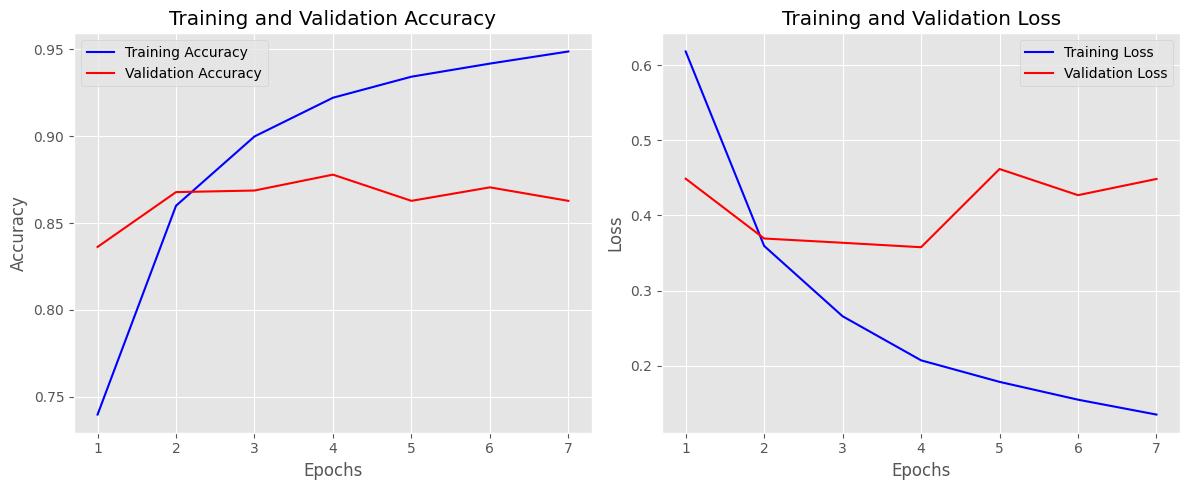

In [9]:
plt.style.use('ggplot')

def plot_history(history):
    acc = history.history['accuracy']
    val_acc = history.history['val_accuracy']
    loss = history.history['loss']
    val_loss = history.history['val_loss']
    epochs = range(1, len(acc) + 1)

    plt.figure(figsize=(12, 5))

    plt.subplot(1, 2, 1)
    plt.plot(epochs, acc, 'b', label='Training Accuracy')
    plt.plot(epochs, val_acc, 'r', label='Validation Accuracy')
    plt.title('Training and Validation Accuracy')
    plt.xlabel('Epochs')
    plt.ylabel('Accuracy')
    plt.legend()

    plt.subplot(1, 2, 2)
    plt.plot(epochs, loss, 'b', label='Training Loss')
    plt.plot(epochs, val_loss, 'r', label='Validation Loss')
    plt.title('Training and Validation Loss')
    plt.xlabel('Epochs')
    plt.ylabel('Loss')
    plt.legend()

    plt.tight_layout()
    plt.show()

%matplotlib inline
plot_history(history)


In [10]:
# Save the model

model.save('model.h5')
print("Model has created!")

Model has created!


In [11]:
input_text = """
kamu jelek banget suaranya  """

def cleansing(sent):
    string = sent.lower()
    string = re.sub(r'[^a-zA-Z0-9]', ' ', string)
    return string

sentiment = ['negative', 'neutral', 'positive']

text = [cleansing(input_text)]
predicted = tokenizer.texts_to_sequences(text)
guess = pad_sequences(predicted, maxlen=X.shape[1])

model = load_model('model.h5')
prediction = model.predict(guess)
polarity = np.argmax(prediction[0])
hasil = sentiment[polarity]

print("Text: %s" % text[0])
print("Sentiment: %s" % sentiment[polarity])

1/1 [==============================] - 0s 140ms/step
Text:  kamu jelek banget suaranya  
Sentiment: negative
